---
title: FID - Zero Filling
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

In Magnetic Resonance, **zero filling** involves artificially extending a dataset in the time domain (FID) or spatial-frequency domain (k-space) by padding it with zeros.

### The Physics of Zero Filling

While it is often mistaken for increasing "true" resolution, zero filling does **not** add new information. According to the Fourier Shift Theorem and DFT properties:

1. **In MRS (Time Domain):** Padding the end of an FID with zeros increases the total number of points fed into the FFT. This acts mathematically as a **sinc interpolation** in the frequency domain, improving the **digital resolution** (the visual spacing between points on the x-axis) and allowing us to better define the true peak shape and position.
2. **In MRI (k-space):** Symmetrically padding the high-frequency edges of k-space decreases the apparent pixel size in the reconstructed image. This reduces **truncation artifacts** (Gibbs ringing) by smoothly interpolating intensity values between the original coarse pixels.

---

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Ensure the accessor is registered
import xmris


## 1. Generating a Realistic FID: Sampled Data

Let's define a function to simulate a multi-component FID with $T_2^*$ decay and specific frequency offsets.

In [3]:
def simulate_fid(t):
    """Simulate a 3-peak FID (doublet + singlet) given a time array."""
    peak1 = 1.0 * np.exp(-t / 0.05) * np.exp(1j * 2 * np.pi * 50 * t)
    peak2 = 0.5 * np.exp(-t / 0.03) * np.exp(1j * 2 * np.pi * 30 * t)
    peak3 = 0.5 * np.exp(-t / 0.03) * np.exp(1j * 2 * np.pi * 70 * t)
    return peak1 + peak2 + peak3


We will simulate a realistic dataset with finite bandwidth.

*(Note: The dwell time must be small enough to satisfy the Nyquist criterion. A 2 ms dwell time yields a 500 Hz spectral width ($\pm 250$ Hz), safely capturing our 70 Hz peak without aliasing).*

In [4]:
# Generate realistically Sampled data
dwell_time = 0.002
bw_sampled = 1 / dwell_time  # 500 Hz
n_points_sampled = 64
t_sampled = np.arange(n_points_sampled) * dwell_time

da_fid_sampled = xr.DataArray(
    simulate_fid(t_sampled),
    dims=["time"],
    coords={"time": t_sampled},
    attrs={"sequence": "FID", "B0": 3.0},
)


## 2. Time-Domain Zero Filling

We apply zero filling to the sampled data, extending it from 64 points to 512 points by padding zeros at the end of the acquisition window.

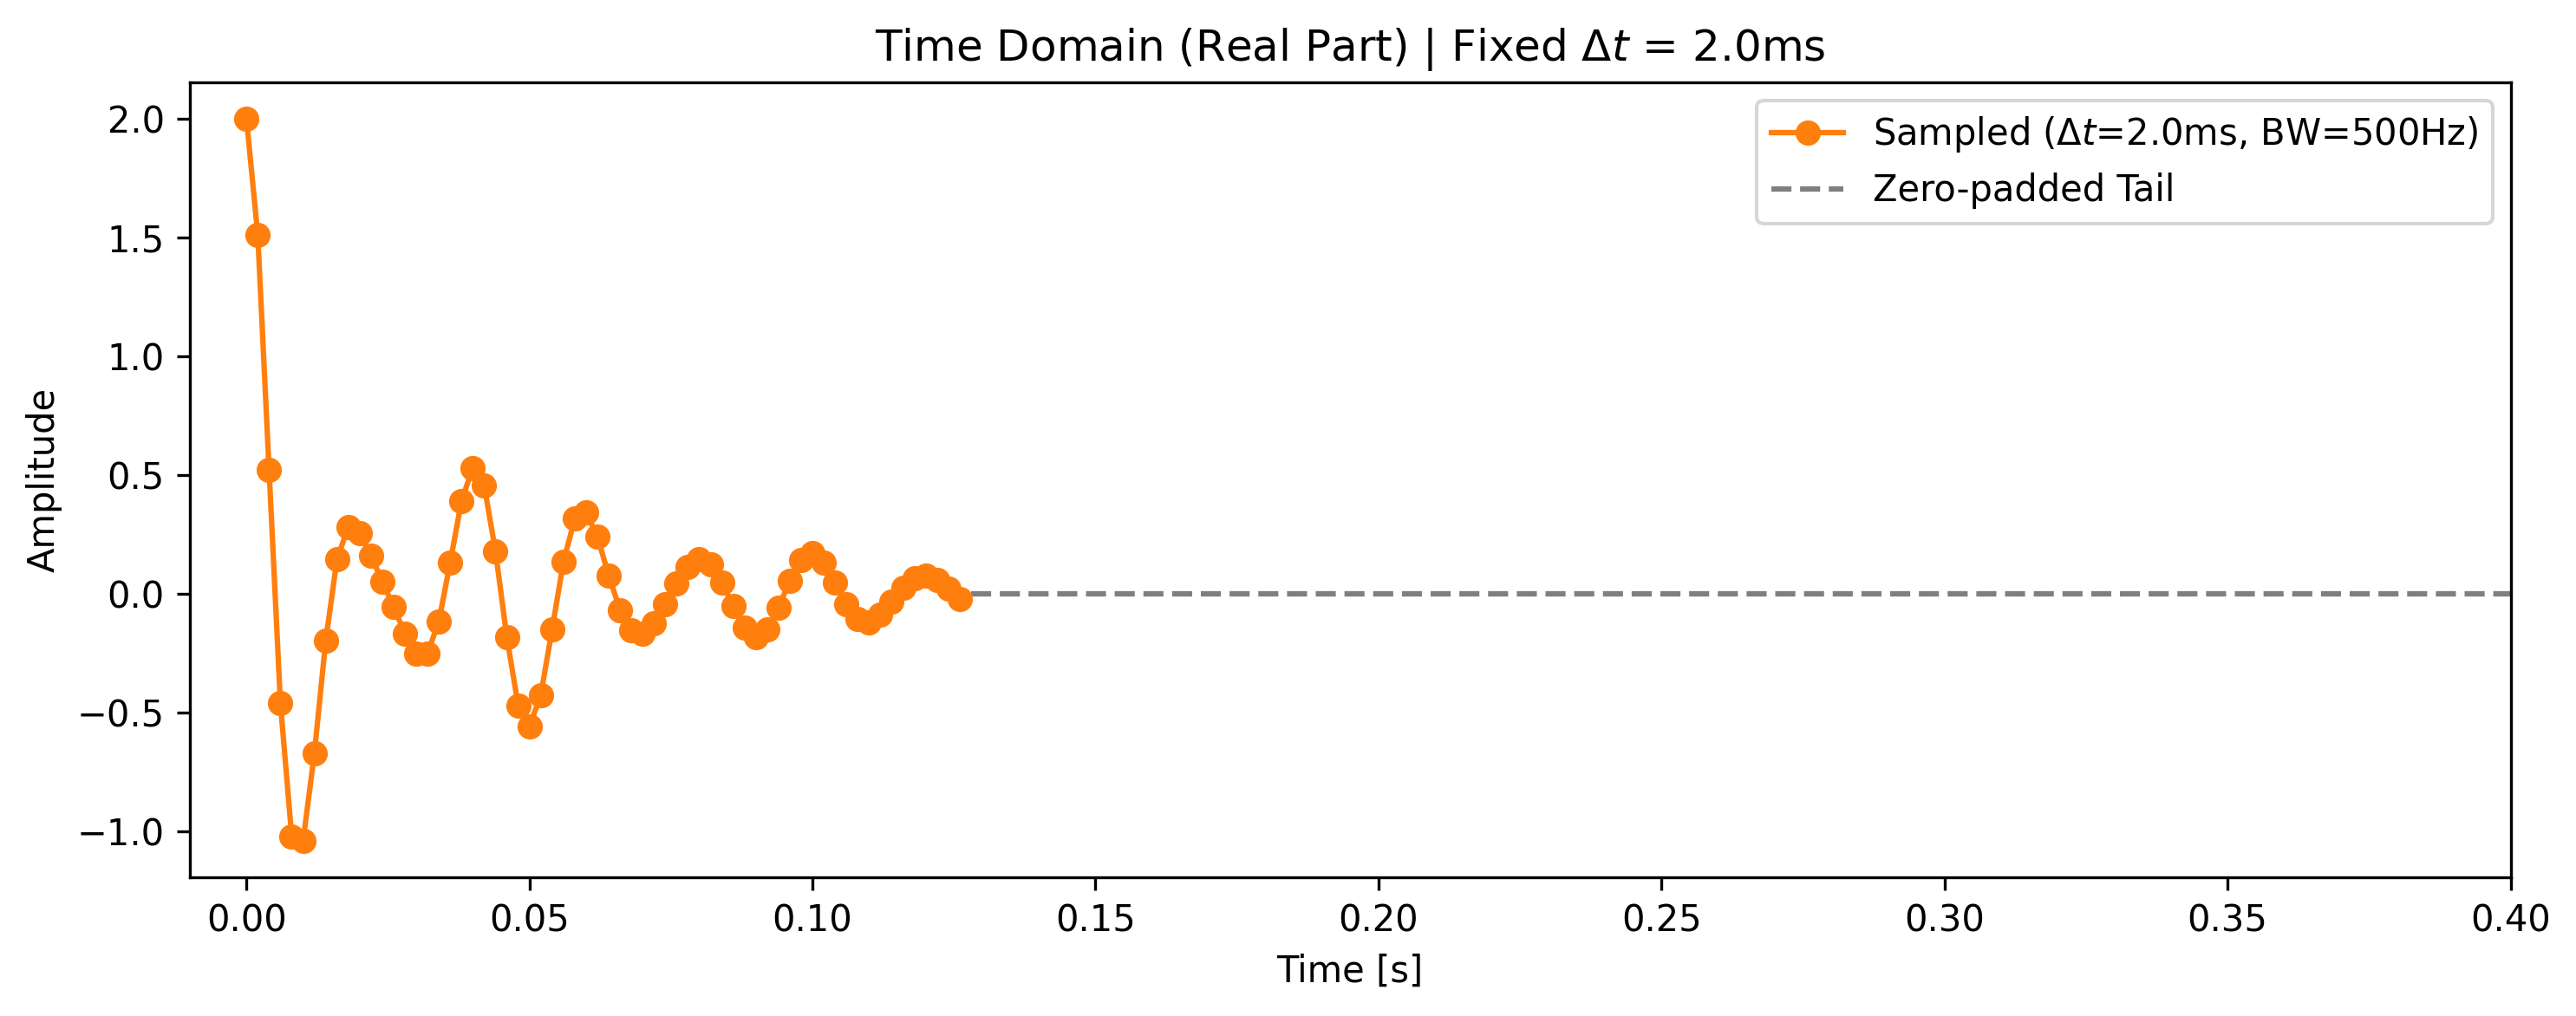

In [5]:
target_points = 512

# Zero fill the sampled array
da_fid_zf = da_fid_sampled.xmr.zero_fill(
    dim="time", target_points=target_points, position="end"
)

fig, ax1 = plt.subplots(figsize=(10, 4))

# Original Sampled Points
da_fid_sampled.real.plot(
    ax=ax1,
    marker="o",
    color="tab:orange",
    linestyle="-",  # Connected to show the original signal path
    label=f"Sampled ($\Delta t$={dwell_time * 1000:.1f}ms, BW={bw_sampled:.0f}Hz)",
    zorder=5,
)

# Zero-filled tail
da_fid_zf.isel(time=slice(n_points_sampled, target_points)).real.plot(
    ax=ax1, color="black", linestyle="--", alpha=0.5, label="Zero-padded Tail"
)


ax1.set_xlim(-0.01, 0.4)
ax1.set_title(f"Time Domain (Real Part) | Fixed $\Delta t$ = {dwell_time * 1000:.1f}ms")
ax1.set_ylabel("Amplitude")
ax1.legend()

plt.tight_layout()
plt.show()


:::{dropdown} Under the Hood: No Magic Strings
As a user, you can pass simple strings like `"time"` and `"frequency"` to `xmris` functions. However, internally, the package never uses raw strings. It maps your input to a strict global vocabulary (`xmris.core.config.DIMS` and `COORDS`).

This architecture allows `xmris` to intercept your request and automatically inject physical metadata (like setting the new coordinate units to `Hz` or `s`) or properly extrapolate coordinate values when extending an array with zeros.

For more info see [xmris Architecture: Why We Built It This Way](https://www.google.com/search?q=./architecture.ipynb)
:::

### Interpolating the Truth (Frequency Domain)

When we transform the zero-filled data, the zeros act as mathematical anchors, forcing the FFT to interpolate the discrete points, resulting in a much smoother spectrum. Note that the peaks do not become narrower (resolution has not increased), but their shapes are better defined.

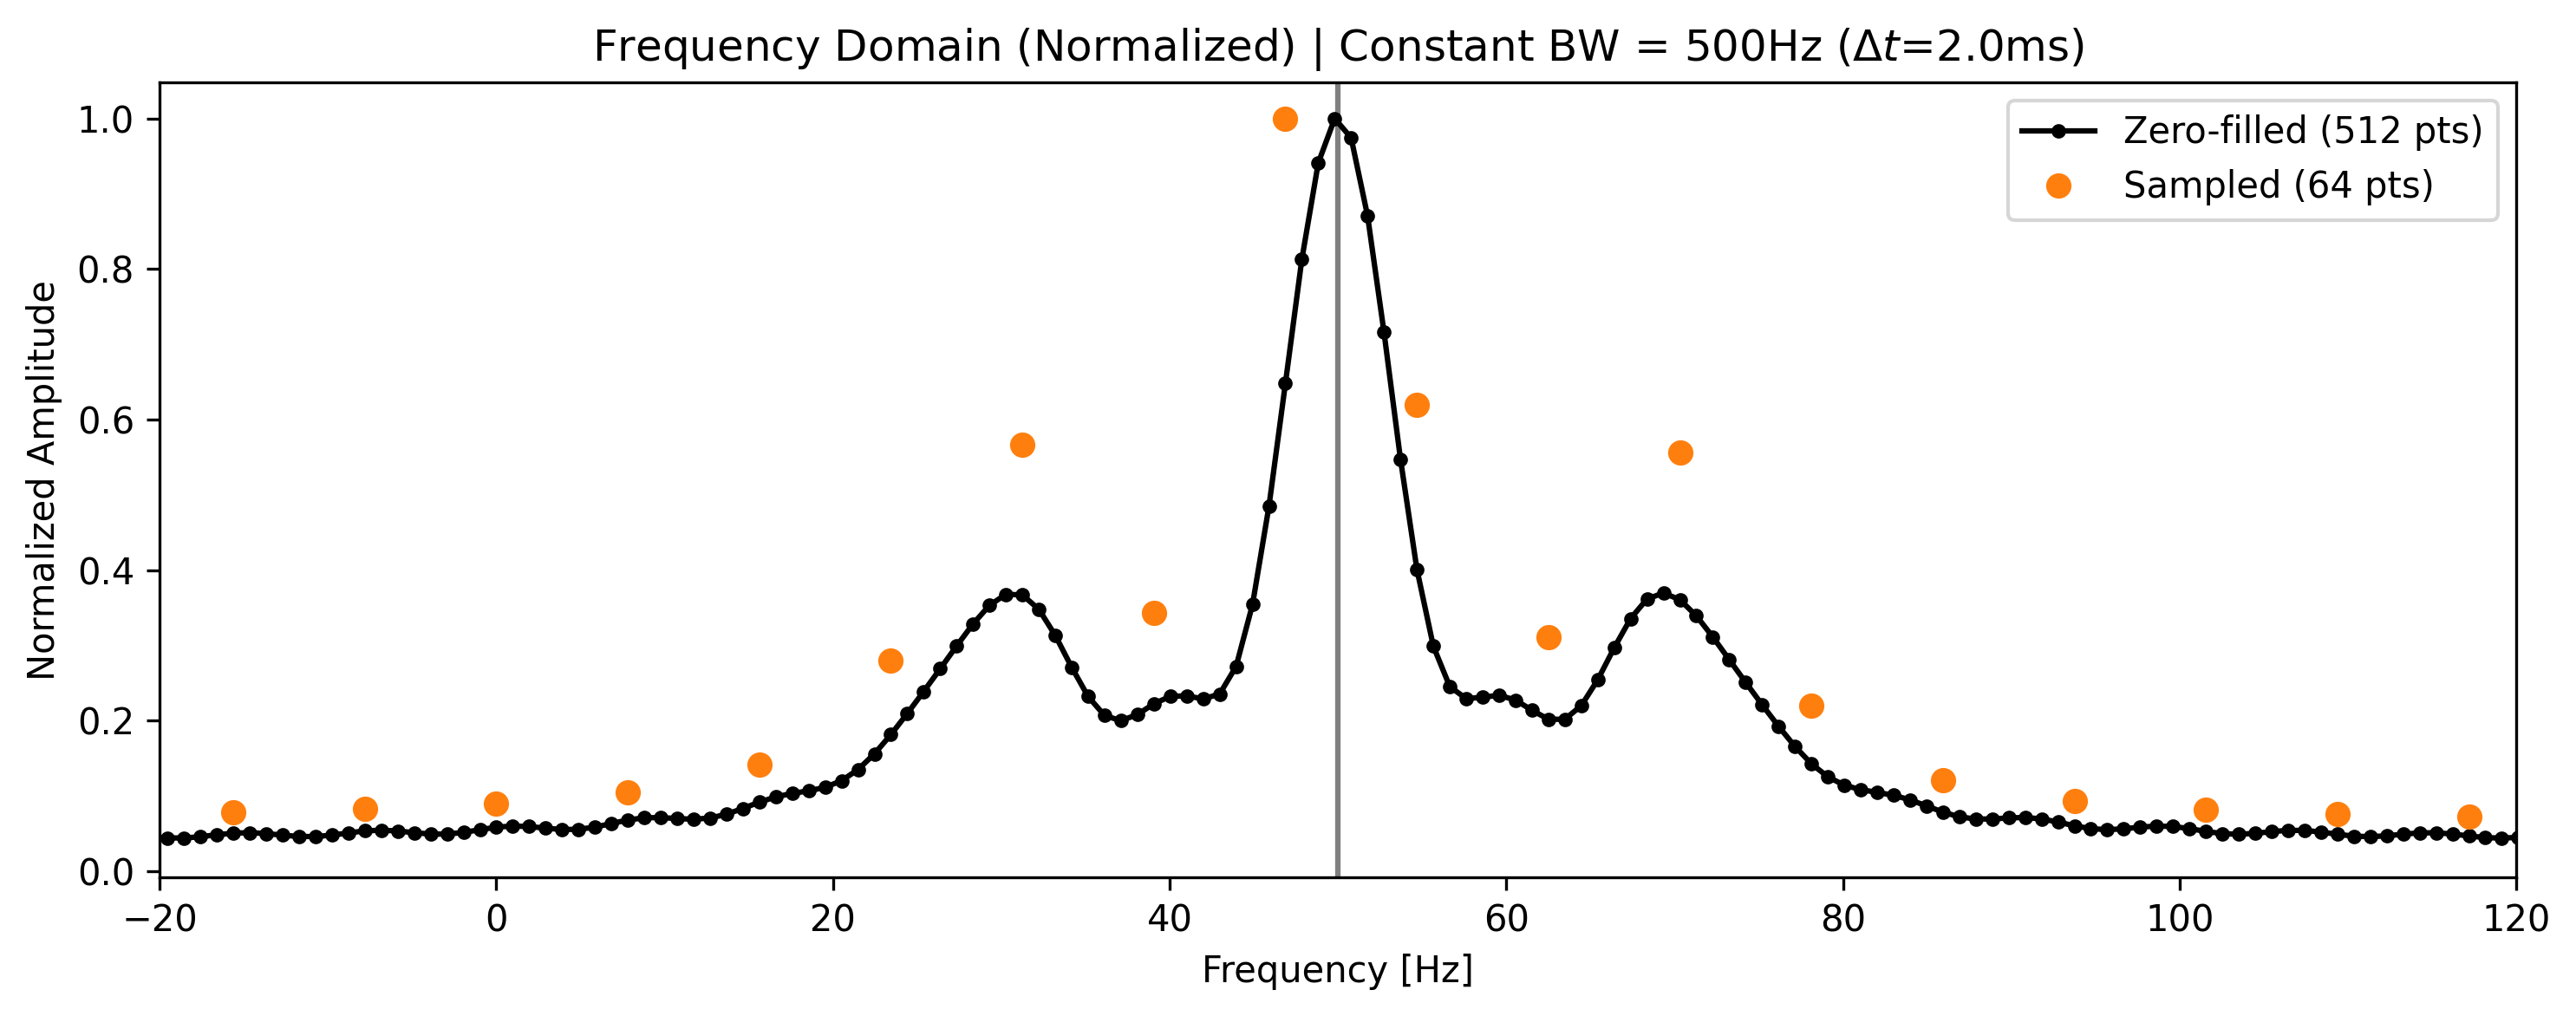

In [6]:
fig, ax2 = plt.subplots(figsize=(10, 4))

spec_sampled = da_fid_sampled.xmr.to_spectrum().real
spec_zf = da_fid_zf.xmr.to_spectrum().real

# Normalize spectra to their maximum value (peak height = 1.0)
spec_sampled_norm = spec_sampled / spec_sampled.max()
spec_zf_norm = spec_zf / spec_zf.max()

# Zero-filled Interpolation
spec_zf_norm.plot(
    ax=ax2,
    color="black",
    marker=".",
    linewidth=1.5,
    label=f"Zero-filled ({target_points} pts)",
    zorder=1,
)
# Original Sampled Points
spec_sampled_norm.plot(
    ax=ax2,
    marker="o",
    markersize=6,
    color="tab:orange",
    label=f"Sampled ({n_points_sampled} pts)",
    zorder=5,
    linestyle="", # Remove lines to emphasize the discrete nature of the raw FFT
)

cf = 50  # centerfreq
ax2.set_xlim(cf - 70, cf + 70)
ax2.axvline(cf, color="gray", zorder=-10)
ax2.set_title(
    f"Frequency Domain (Normalized) | Constant BW = {bw_sampled:.0f}Hz ($\Delta t$={dwell_time * 1000:.1f}ms)"
)
ax2.set_ylabel("Normalized Amplitude")
ax2.legend()

plt.tight_layout()
plt.show()


In [7]:
# STRICT TESTS: Time-Domain Zero Filling (End padding)
_target_points = 512
_current_points = da_fid_sampled.sizes["time"]
_pad_size = _target_points - _current_points

# Prove math (padding with zeros)
np.testing.assert_array_equal(
    da_fid_zf.values[:_current_points], da_fid_sampled.values,
    err_msg="Original data altered during padding."
)
np.testing.assert_array_equal(
    da_fid_zf.values[_current_points:], np.zeros(_pad_size),
    err_msg="Padded values are not zero."
)

# Prove coordinate extrapolation
_dt = da_fid_sampled.coords["time"].values[1] - da_fid_sampled.coords["time"].values[0]
_expected_coords = np.arange(_target_points) * _dt
np.testing.assert_allclose(
    da_fid_zf.coords["time"].values, _expected_coords,
    err_msg="Coordinate extrapolation failed."
)

# Prove lineage stamping and attribute preservation
for k, v in da_fid_sampled.attrs.items():
    assert da_fid_zf.attrs[k] == v, f"Original attribute '{k}' was dropped."
assert da_fid_zf.attrs.get("zero_fill_target") == _target_points, "Lineage failed: missing target points."
assert da_fid_zf.attrs.get("zero_fill_position") == "end", "Lineage failed: missing position flag."

---

## 3. Spatial Frequency Zero Filling (2D K-Space)

In MRI imaging, we zero-fill k-space symmetrically to artificially boost the digital resolution matrix (e.g., from 32x32 to 128x128).

In [8]:
# Create a low-res 32x32 k-space grid
N = 32
k_vec = np.linspace(-N // 2, N // 2 - 1, N)
kx, ky = np.meshgrid(k_vec, k_vec)

# Physics: A rectangular object in image space is a 2D sinc in k-space
kspace_2d = np.sinc(kx / 6) * np.sinc(ky / 6)
da_k2d = xr.DataArray(
    kspace_2d + 0j, dims=["ky", "kx"], coords={"ky": k_vec, "kx": k_vec}, attrs={"domain": "k-space"}
)

# Symmetrically Zero-fill to 128x128
target_k_points = 128
da_k2d_zf = da_k2d.xmr.zero_fill(dim="kx", target_points=target_k_points, position="symmetric")
da_k2d_zf = da_k2d_zf.xmr.zero_fill(dim="ky", target_points=target_k_points, position="symmetric")


### Image Reconstruction

Transforming back to image space demonstrates how zero-filling smooths the blocky pixels of the low-resolution acquisition. Because we use symmetric padding in k-space, the resulting image remains centered.

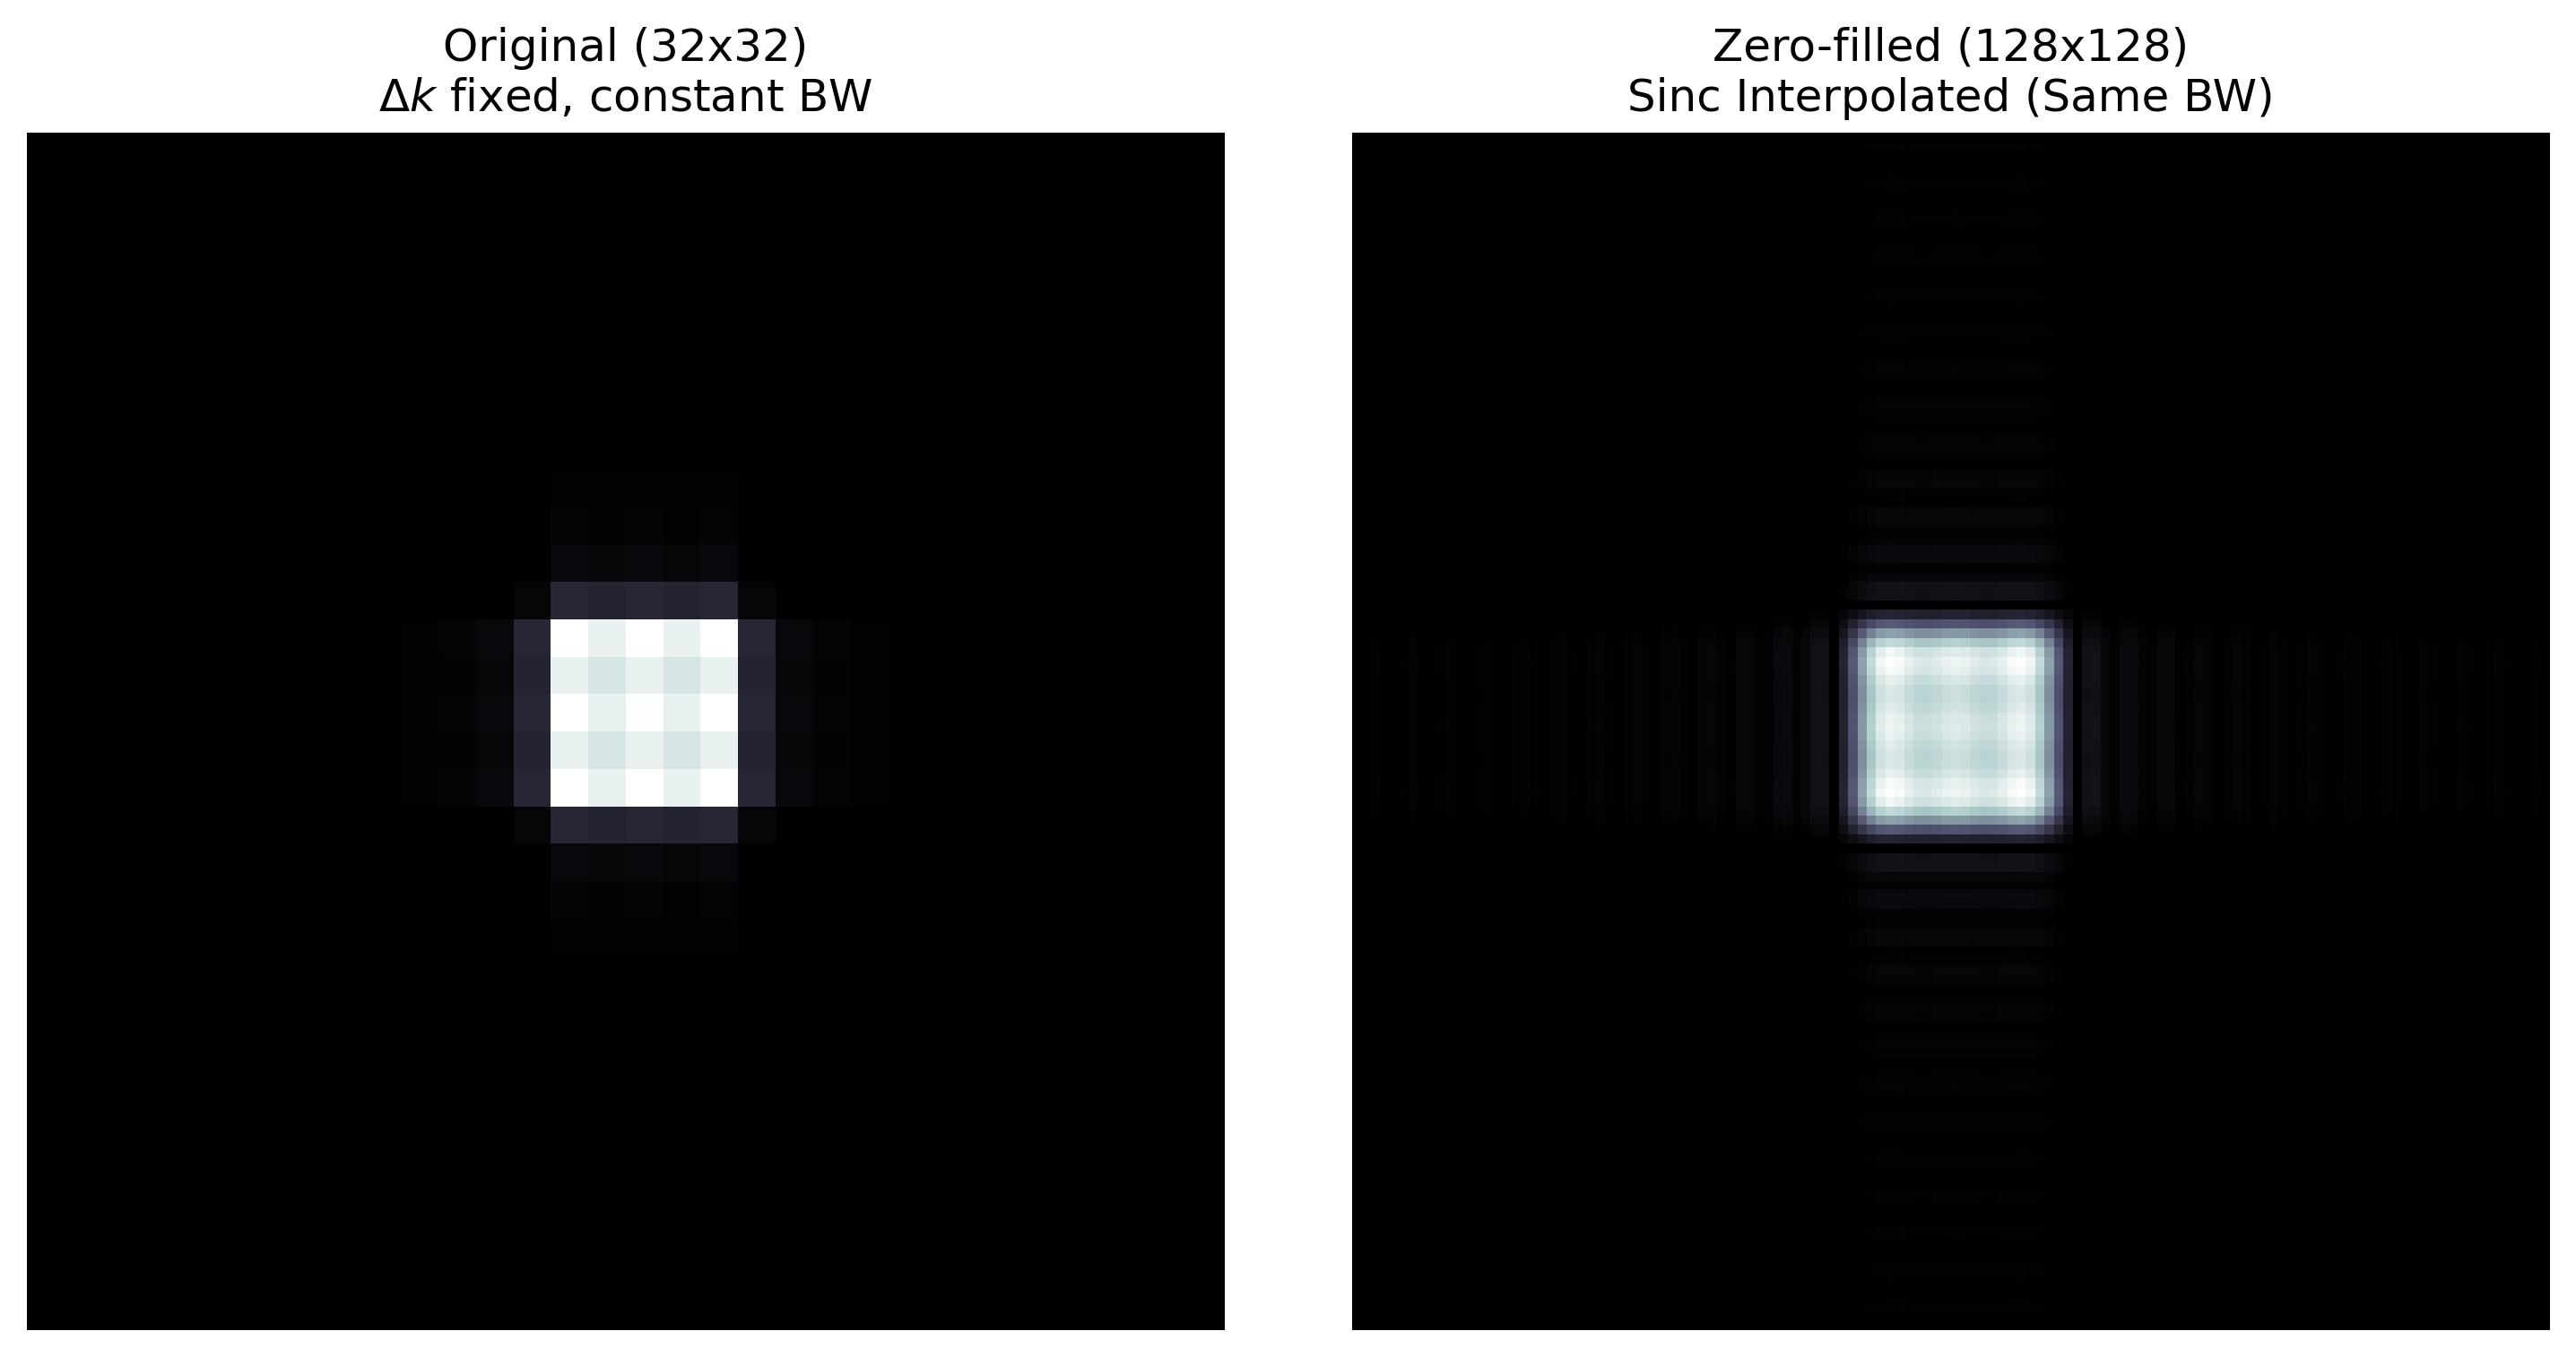

In [9]:
# Transform to image space (using standard centered FFT functions from xmris)
# Note: In a real xmris pipeline, we would use a dedicated spatial transform,
# but for this demonstration we will use numpy's generic ifftn/ifftshift.
img_orig = np.abs(np.fft.ifftshift(np.fft.ifftn(np.fft.fftshift(da_k2d.values))))
img_zf = np.abs(np.fft.ifftshift(np.fft.ifftn(np.fft.fftshift(da_k2d_zf.values))))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_orig, cmap="bone", origin="lower")
axes[0].set_title(f"Original ({N}x{N})\n$\Delta k$ fixed, constant BW")

axes[1].imshow(img_zf, cmap="bone", origin="lower")
axes[1].set_title(f"Zero-filled ({target_k_points}x{target_k_points})\nSinc Interpolated (Same BW)")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [10]:
# STRICT TESTS: Symmetric K-Space Zero Filling
_target_k_points = 128
_current_k_points = 32
_pad_size_k = _target_k_points - _current_k_points
_pad_left = _pad_size_k // 2
_pad_right = _pad_size_k - _pad_left

# Prove math (symmetric padding with zeros on one axis for testing)
_da_test_sym = da_k2d.xmr.zero_fill(dim="kx", target_points=_target_k_points, position="symmetric")

# Center block should be the original data
np.testing.assert_array_equal(
    _da_test_sym.values[:, _pad_left: _pad_left + _current_k_points], da_k2d.values,
    err_msg="Original k-space data altered during symmetric padding."
)
# Edges should be zero
np.testing.assert_array_equal(
    _da_test_sym.values[:, :_pad_left], 0, err_msg="Left padded values are not zero."
)
np.testing.assert_array_equal(
    _da_test_sym.values[:, -_pad_right:], 0, err_msg="Right padded values are not zero."
)

# Prove coordinate extrapolation
_dk = da_k2d.coords["kx"].values[1] - da_k2d.coords["kx"].values[0]
_start_k = da_k2d.coords["kx"].values[0] - (_pad_left * _dk)
_expected_k_coords = _start_k + np.arange(_target_k_points) * _dk
np.testing.assert_allclose(
    _da_test_sym.coords["kx"].values, _expected_k_coords,
    err_msg="Coordinate extrapolation failed for symmetric padding."
)

# Prove lineage stamping
assert _da_test_sym.attrs.get("zero_fill_target") == _target_k_points, "Lineage failed."
assert _da_test_sym.attrs.get("zero_fill_position") == "symmetric", "Lineage failed."